# Object Detection Project (WIP)

dataset:  https://github.com/Shenggan/BCCD_Dataset

The purpose of this project is to train a RCNN that detects different
blood cell types in an image and create a bounding box around
the detected objects.

In [ ]:
import numpy as np
import os
#import tensorflow as tf
import cv2
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt


In [ ]:
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.
fatal: destination path 'vision' already exists and is not an empty directory.
/content/vision
HEAD is now at be376084d version check against PyTorch's CUDA version
/content


#### Read data

In [ ]:
df = pd.read_csv('/content/BCCD_Dataset/test.csv')
print(df)

                  filename  cell_type  xmin  xmax  ymin  ymax
0     BloodImage_00000.jpg        WBC   260   491   177   376
1     BloodImage_00000.jpg        RBC    78   184   336   435
2     BloodImage_00000.jpg        RBC    63   169   237   336
3     BloodImage_00000.jpg        RBC   214   320   362   461
4     BloodImage_00000.jpg        RBC   414   506   352   445
...                    ...        ...   ...   ...   ...   ...
4883  BloodImage_00410.jpg  Platelets   239   291   275   321
4884  BloodImage_00410.jpg  Platelets   121   189   260   320
4885  BloodImage_00410.jpg  Platelets    57   104   119   167
4886  BloodImage_00410.jpg  Platelets     1    29   286   327
4887  BloodImage_00410.jpg        WBC   367   611   166   394

[4888 rows x 6 columns]


#### Data Preprocessing

In [ ]:
class_names = [_, 'Platelets', 'RBC', 'WBC']

In [ ]:
# Numerically encode data labels
le = preprocessing.LabelEncoder()
le.fit(class_names)
df['cell_type'] = le.transform(df['cell_type'])

In [ ]:
# Normalize bounding box values
imgWidth = 640
imgHeight = 480
df['xmin'] /= imgWidth
df['xmax'] /= imgWidth
df['ymin'] /= imgHeight
df['ymax'] /= imgHeight

In [ ]:
# Add column for the index of the image
imgNames = pd.unique(df['filename'])
le = preprocessing.LabelEncoder()
le.fit(imgNames)
df['imgs_idx'] = le.transform(df['filename'])
print(df)

                  filename  cell_type      xmin      xmax      ymin      ymax  \
0     BloodImage_00000.jpg          3  0.406250  0.767188  0.368750  0.783333   
1     BloodImage_00000.jpg          2  0.121875  0.287500  0.700000  0.906250   
2     BloodImage_00000.jpg          2  0.098437  0.264062  0.493750  0.700000   
3     BloodImage_00000.jpg          2  0.334375  0.500000  0.754167  0.960417   
4     BloodImage_00000.jpg          2  0.646875  0.790625  0.733333  0.927083   
...                    ...        ...       ...       ...       ...       ...   
4883  BloodImage_00410.jpg          1  0.373437  0.454688  0.572917  0.668750   
4884  BloodImage_00410.jpg          1  0.189062  0.295312  0.541667  0.666667   
4885  BloodImage_00410.jpg          1  0.089063  0.162500  0.247917  0.347917   
4886  BloodImage_00410.jpg          1  0.001563  0.045312  0.595833  0.681250   
4887  BloodImage_00410.jpg          3  0.573438  0.954688  0.345833  0.820833   

      imgs_idx  
0         

In [ ]:
# Filename column no longer needed
df = df.drop(columns=['filename'])
print(df)

      cell_type      xmin      xmax      ymin      ymax  imgs_idx
0             3  0.406250  0.767188  0.368750  0.783333         0
1             2  0.121875  0.287500  0.700000  0.906250         0
2             2  0.098437  0.264062  0.493750  0.700000         0
3             2  0.334375  0.500000  0.754167  0.960417         0
4             2  0.646875  0.790625  0.733333  0.927083         0
...         ...       ...       ...       ...       ...       ...
4883          1  0.373437  0.454688  0.572917  0.668750       363
4884          1  0.189062  0.295312  0.541667  0.666667       363
4885          1  0.089063  0.162500  0.247917  0.347917       363
4886          1  0.001563  0.045312  0.595833  0.681250       363
4887          3  0.573438  0.954688  0.345833  0.820833       363

[4888 rows x 6 columns]


#### Data Augmentation

In [ ]:
# Renaming images in directory to assist with augmentation since some numbers are skipped 
os.chdir('/content/BCCD_Dataset/BCCD/JPEGImages/')
print(os.getcwd())
for idx, name in enumerate(imgNames):    

  os.rename(name, str(idx).zfill(4)+'.jpg')

/content/BCCD_Dataset/BCCD/JPEGImages


FileNotFoundError: ignored

In [ ]:
originalImageCount = len(imgNames)

# Flip images upside down and add to directory


# Load in images from directory and apply flip, then save as a new image with proper name
print(os.getcwd())
for i in range(originalImageCount):
    cv2.imwrite((str(originalImageCount + i).zfill(4))+'.jpg', 
                np.flipud(cv2.imread(str(i).zfill(4)+'.jpg')))


# Adjust bounding box to flip on dataframe since the flip will change
# the bounding box x and y values
dfFlipped = df.copy(deep=True)
dfFlipped['ymin'] = 1 - df['ymax']
dfFlipped['ymax'] = 1 - df['ymin']
dfFlipped['imgs_idx'] = df['imgs_idx'] + originalImageCount
print(dfFlipped)

/content/BCCD_Dataset/BCCD/JPEGImages
      cell_type      xmin      xmax      ymin      ymax  imgs_idx
0             3  0.406250  0.767188  0.216667  0.631250       364
1             2  0.121875  0.287500  0.093750  0.300000       364
2             2  0.098437  0.264062  0.300000  0.506250       364
3             2  0.334375  0.500000  0.039583  0.245833       364
4             2  0.646875  0.790625  0.072917  0.266667       364
...         ...       ...       ...       ...       ...       ...
4883          1  0.373437  0.454688  0.331250  0.427083       727
4884          1  0.189062  0.295312  0.333333  0.458333       727
4885          1  0.089063  0.162500  0.652083  0.752083       727
4886          1  0.001563  0.045312  0.318750  0.404167       727
4887          3  0.573438  0.954688  0.179167  0.654167       727

[4888 rows x 6 columns]


In [ ]:
# Repeat above steps but with mirroring images along y-axis
print(os.getcwd())
for i in range(originalImageCount):
    cv2.imwrite((str(originalImageCount*2 + i).zfill(4))+'.jpg', 
                np.fliplr(cv2.imread(str(i).zfill(4)+'.jpg')))


# Adjust bounding box to flip on dataframe since the flip will change
# the bounding box x and y values
dfMirrored = df.copy(deep=True)
dfMirrored['xmin'] = 1 - df['xmax']
dfMirrored['xmax'] = 1 - df['xmin']
dfMirrored['imgs_idx'] = dfFlipped['imgs_idx'] + originalImageCount
print(dfMirrored)


/content/BCCD_Dataset/BCCD/JPEGImages
      cell_type      xmin      xmax      ymin      ymax  imgs_idx
0             3  0.232812  0.593750  0.368750  0.783333       728
1             2  0.712500  0.878125  0.700000  0.906250       728
2             2  0.735938  0.901563  0.493750  0.700000       728
3             2  0.500000  0.665625  0.754167  0.960417       728
4             2  0.209375  0.353125  0.733333  0.927083       728
...         ...       ...       ...       ...       ...       ...
4883          1  0.545312  0.626563  0.572917  0.668750      1091
4884          1  0.704688  0.810937  0.541667  0.666667      1091
4885          1  0.837500  0.910937  0.247917  0.347917      1091
4886          1  0.954688  0.998437  0.595833  0.681250      1091
4887          3  0.045312  0.426562  0.345833  0.820833      1091

[4888 rows x 6 columns]


In [ ]:
import matplotlib.patches as patches

# Function to show image with bounding boxes
def plot_boxes(img, boxes, labels):
    imgHeight, imgWidth = np.shape(img)[0], np.shape(img)[1]
    
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    #Draw red box for red blood cell, white for white blood cell, and blue for platelet
    for box in boxes:
        if box[4] == 1:
            width = (box[1]-box[0])*imgWidth
            height = (box[3]-box[2])*imgHeight
            rect = patches.Rectangle(
                (box[0]*imgWidth, box[2]*imgHeight),
                width, height,
                linewidth = 2,
                edgecolor = 'b',
                facecolor = 'none'
            )
        if box[4] == 2:
            width = (box[1]-box[0])*imgWidth
            height = (box[3]-box[2])*imgHeight
            rect = patches.Rectangle(
                (box[0]*imgWidth, box[2]*imgHeight),
                width, height,
                linewidth = 2,
                edgecolor = 'r',
                facecolor = 'none'
            )
        if box[4] == 3:
            width = (box[1]-box[0])*imgWidth
            height = (box[3]-box[2])*imgHeight
            rect = patches.Rectangle(
                (box[0]*imgWidth, box[2]*imgHeight),
                width, height,
                linewidth = 2,
                edgecolor = 'w',
                facecolor = 'none'
            )
    # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

In [ ]:
df = pd.concat([df, dfFlipped, dfMirrored], ignore_index=True)
print(df)


       cell_type      xmin      xmax      ymin      ymax  imgs_idx
0              3  0.406250  0.767188  0.368750  0.783333         0
1              2  0.121875  0.287500  0.700000  0.906250         0
2              2  0.098437  0.264062  0.493750  0.700000         0
3              2  0.334375  0.500000  0.754167  0.960417         0
4              2  0.646875  0.790625  0.733333  0.927083         0
...          ...       ...       ...       ...       ...       ...
14659          1  0.545312  0.626563  0.572917  0.668750      1091
14660          1  0.704688  0.810937  0.541667  0.666667      1091
14661          1  0.837500  0.910937  0.247917  0.347917      1091
14662          1  0.954688  0.998437  0.595833  0.681250      1091
14663          3  0.045312  0.426562  0.345833  0.820833      1091

[14664 rows x 6 columns]


Empty DataFrame
Columns: [cell_type, xmin, xmax, ymin, ymax, imgs_idx]
Index: []


Demonstrated the data augmentation by showing the regular image and the flipped and mirrored versions.
The bounding box for the red blood cell is red, white for the white blood cell, and blue for platelets.

In [ ]:
idx = 15
boxes = df.where(df['imgs_idx']==idx)[['xmin', 'xmax', 'ymin', 'ymax', 'cell_type']].dropna().to_numpy()
plot_boxes(cv2.cvtColor(cv2.imread('0015.jpg').astype('uint8'), cv2.COLOR_BGR2RGB), boxes, )

boxes = df.where(df['imgs_idx']==idx+364)[['xmin', 'xmax', 'ymin', 'ymax', 'cell_type']].dropna().to_numpy()
plot_boxes(cv2.cvtColor(cv2.imread('0379.jpg').astype('uint8'), cv2.COLOR_BGR2RGB), boxes)

boxes = df.where(df['imgs_idx']==idx+728)[['xmin', 'xmax', 'ymin', 'ymax', 'cell_type']].dropna().to_numpy()
plot_boxes(cv2.cvtColor(cv2.imread('0743.jpg').astype('uint8'), cv2.COLOR_BGR2RGB), boxes)

AttributeError: ignored

### Dataset and Dataset loader class
Pytorch requires a class to process the data to the correct format and a dataset loader class which feeds the model the data for training and testing


In [ ]:
os.chdir('/content/')
# we create a Dataset class which has a __getitem__ function and a __len__ function
class BloodCellDataset(torch.utils.data.Dataset):

  def __init__(self, width, height, classes, transforms=None):
    self.height = height
    self.width = width
    
    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    # classes: 0 index is reserved for background
    self.classes = classes

  def __getitem__(self, idx):
    # reading the images and converting them to correct size and color
    img = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/'+str(idx).zfill(4)+'.jpg')    
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB).astype(np.float32)
    img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
    
    # normalize
    img/=255.0

    # Change array from channels last to channels first
    img = np.moveaxis(img, -1, 0)
    
    
    boxes = df.where(df['imgs_idx']==idx)[['xmin', 'ymin', 'xmax', 'ymax']].dropna().to_numpy()
    labels = df.where(df['imgs_idx']==idx)['cell_type'].dropna().to_numpy()
    
    # cv2 image gives size as height x width
    imageWidth = img.shape[1]
    imageHeight = img.shape[0]
    
    
    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
    # getting the areas of the boxes
    area = (boxes[:, 1] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 2])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    return torch.tensor(img), target

  def __len__(self):
    return 1091

Length of dataset: 1091 

Image shape: torch.Size([3, 224, 224])
Label example: {'boxes': tensor([[0.2266, 0.0083, 0.5641, 0.5000],
        [0.5516, 0.2812, 0.6687, 0.4833],
        [0.5531, 0.0250, 0.7000, 0.2667],
        [0.6875, 0.1625, 0.8438, 0.3333],
        [0.8391, 0.0979, 0.9969, 0.3000],
        [0.6797, 0.0021, 0.8406, 0.1562],
        [0.6422, 0.7479, 0.8156, 0.9563],
        [0.4156, 0.8521, 0.5844, 1.0000],
        [0.0016, 0.8250, 0.2094, 1.0000],
        [0.0016, 0.5667, 0.1594, 0.7896],
        [0.0969, 0.1292, 0.2578, 0.3521],
        [0.3875, 0.4187, 0.5484, 0.6417],
        [0.1422, 0.6250, 0.3187, 0.8146],
        [0.8813, 0.2917, 1.0000, 0.5000],
        [0.4547, 0.7771, 0.5266, 0.8542],
        [0.5828, 0.4208, 0.7563, 0.6292]]), 'labels': tensor([3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]), 'area': tensor([0.0140, 0.0501, 0.2289, 0.2680, 0.5165, 0.4637, 0.0149, 0.1814, 0.6510,
        0.3561, 0.0030, 0.0029, 0.2394, 0.2948, 0.1056, 0.0206]), 'iscrowd': ten

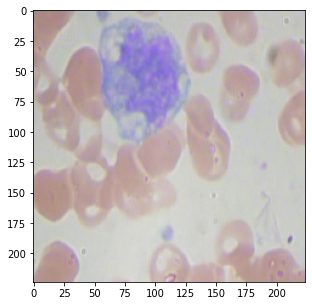

In [ ]:
# check dataset

dataset = BloodCellDataset(224, 224, class_names)
dataset_test = BloodCellDataset(224, 224, class_names)
print('Length of dataset:', len(dataset), '\n')
# getting the image and target for a test index.  Feel free to change the index.

img, target = dataset[15]
print('Image shape:', img.shape)
print('Label example:', target)
fig, a = plt.subplots(1,1)
fig.set_size_inches(5,5)
# Convert from torch tensor not numpy then move channels last
img = np.moveaxis(img.cpu().detach().numpy(), 0, -1)
a.imshow(img)


In [ ]:
# Train/test split
test_split = 0.2
indices = torch.randperm(len(dataset)).tolist()
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])


In [ ]:
import utils
import transforms as T
# Define data_loader which will feed data into neural net
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=16,
  shuffle=True,
  num_workers=2,
  collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=16,
  shuffle=False,
  num_workers=2,
  collate_fn=utils.collate_fn
)

#### Transfer Learning

For this project I am using the Faster R-CNN ResNet 50 that is pretrained wuth the COCO dataset.

In [ ]:
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(class_names) # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Helper functions for training
from engine import train_one_epoch, evaluate


num_epochs = 5

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/55]  eta: 2:52:39  lr: 0.000195  loss: 6.3119 (6.3119)  loss_classifier: 1.6025 (1.6025)  loss_box_reg: 0.0432 (0.0432)  loss_objectness: 3.4161 (3.4161)  loss_rpn_box_reg: 1.2500 (1.2500)  time: 188.3539  data: 0.5665  max mem: 0


KeyboardInterrupt: ignored